In [186]:
import email
import os
import re
import pandas as pd

# function to extract and store date and time information in an Excel file
def extract_and_store_datetime(eml_file, output_file):
    with open(eml_file, 'r', encoding='utf-8') as file:
        email_message = file.read()

    msg = email.message_from_string(email_message)

    # Extracting sender, sent date and time, X-Received, and Received headers
    sender = msg['From']
    sent_date = extract_datetime_from_header(msg['Date'])
    x_received_headers = extract_datetime_from_header('; '.join(msg.get_all('X-Received')))
    received_headers = [extract_datetime_from_header(header) for header in msg.get_all('Received')]

    # Creating a DataFrame to store the extracted information
    data = {
        'From': [sender],
        'Sent': [sent_date],
        'X-Received': [x_received_headers],
    }

    for i, header_date in enumerate(received_headers):
        header_label = f'Received_{i + 1}'
        data[header_label] = [header_date]

    # Creating and appending to the Excel file
    if os.path.exists(output_file):
        df = pd.read_csv(output_file)
        df = df.append(pd.DataFrame(data), ignore_index=True)
    else:
        df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_csv(output_file, index=False)

# Defining a function to extract date and time from header
def extract_datetime_from_header(header):
    date_time_pattern = re.compile(r'\w+, \d+ \w+ \d+ \d+:\d+:\d+ [-+]\d+(?: \([A-Z]+\))?|\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+ [-+]\d+ UTC')
    dates_and_times = date_time_pattern.findall(header)
    return '; '.join(dates_and_times)

# Specifying the directory where .eml files are located
eml_directory = './files'

# Creating an output Excel file
output_file = '100_email.csv'

# Looping through .eml files in the specified directory
for filename in os.listdir(eml_directory):
    if filename.endswith('.eml'):
        eml_file_path = os.path.join(eml_directory, filename)
        print(f'Processing: {eml_file_path}')
        extract_and_store_datetime(eml_file_path, output_file)

# Loading the data from the CSV file
data = pd.read_csv('100_email.csv')

# Defining a function to remove words in parentheses (e.g., (UTC), (PDT), etc.) and standalone timezone identifiers (e.g., UTC)
def remove_timezone_identifiers(cell):
    # Using a regular expression to remove words in parentheses or standalone timezone identifiers
    return re.sub(r'\s*\([^)]*\)|\b[A-Z]+\b', '', cell) if pd.notna(cell) else cell

# Applying the function to relevant columns
data['Sent'] = data['Sent'].apply(remove_timezone_identifiers)
data['X-Received'] = data['X-Received'].apply(remove_timezone_identifiers)

for col in data.columns:
    if col.startswith('Received'):
        data[col] = data[col].apply(remove_timezone_identifiers)

# Saving the cleaned data back to the CSV file
data.to_csv('100_email_cleaned.csv', index=False)

import pandas as pd
import re

# Loading the cleaned data from the CSV file
data = pd.read_csv('100_email_cleaned.csv')

# Defining a function to extract the time and timezone
def extract_time_and_timezone(cell):
    if isinstance(cell, str):
        # Using a regular expression to capture the time and timezone
        time_zone_pattern = re.compile(r'(\d{2}:\d{2}:\d{2}\s*[-+]\d{4})')
        match = time_zone_pattern.search(cell)
        if match:
            return match.group(1)
    return None

# Creating new columns for extracted time and timezone in the desired format
data['Sent_time_and_timezone'] = data['Sent'].apply(extract_time_and_timezone)
data['X-Received_time_and_timezone'] = data['X-Received'].apply(extract_time_and_timezone)

for i in range(1, 5):  # For Received_1 to Received_4
    col_name = f'Received_{i}'
    new_col_name = f'Received_{i}_time_and_timezone'
    data[new_col_name] = data[col_name].apply(extract_time_and_timezone)

# Saving the data with extracted time and timezone in the desired format to a new CSV file
data.to_csv('100_email_with_time_and_timezone.csv', index=False)

import pandas as pd
import pytz
from datetime import datetime

# Loading the data from the CSV file with time and timezone columns
data = pd.read_csv('100_email_with_time_and_timezone.csv')

def convert_to_sast(time_str):
    try:
        if pd.notna(time_str) and time_str.strip():
            # Creating a datetime object from the time string and original timezone
            dt = datetime.strptime(time_str, '%H:%M:%S %z')

            # Converting the time to South African Time (SAST)
            sast_timezone = pytz.timezone('Africa/Johannesburg')
            dt_sast = dt.astimezone(sast_timezone)

            # Extracting and formating the time in HH:MM:SS
            return dt_sast.strftime('%H:%M:%S')
        else:
            return None  # Return None for missing or empty values
    except ValueError:
        return None

data['Sent_sa'] = data['Sent_time_and_timezone'].apply(convert_to_sast)
data['X-Received_sa'] = data['X-Received_time_and_timezone'].apply(convert_to_sast)

for i in range(1, 5):
    col_name = f'Received_{i}_time_and_timezone'
    new_col_name = f'Received_{i}_sa'
    data[new_col_name] = data[col_name].apply(convert_to_sast)

# Saving the data with converted times to South African Time in new columns
data.to_csv('100_email_with_time_to_sa.csv', index=False)

# Defining a function to calculate the time difference
def calculate_time_difference(row):
    times = [row['X-Received_sa']]  # Add X-Received_sa to the list of times

    # Checking if Received_1_sa exists and is not empty
    if pd.notna(row['Received_1_sa']) and row['Received_1_sa'].strip():
        times.append(row['Received_1_sa'])

    # Checking if Received_2_sa exists and is not empty
    if pd.notna(row['Received_2_sa']) and row['Received_2_sa'].strip():
        times.append(row['Received_2_sa'])

    # Checking if Received_3_sa exists and is not empty
    if pd.notna(row['Received_3_sa']) and row['Received_3_sa'].strip():
        times.append(row['Received_3_sa'])

    # Checking if Received_4_sa exists and is not empty
    if pd.notna(row['Received_4_sa']) and row['Received_4_sa'].strip():
        times.append(row['Received_4_sa'])

    if times:
        # Finding the maximum time from the list of times
        max_time = max(times)

        # Converting the time strings to datetime objects
        sent_time = datetime.strptime(row['Sent_sa'], '%H:%M:%S')
        max_time = datetime.strptime(max_time, '%H:%M:%S')

        # Calculating the time difference in seconds
        time_difference = (max_time - sent_time).total_seconds()
        return time_difference
    else:
        return None

# Creating the Time_Difference column in seconds
data['Time_Difference (sec)'] = data.apply(calculate_time_difference, axis=1)

# Saving the data with the Time_Difference column
data.to_csv('100_email_with_time_difference.csv', index=False)


Processing: ./files\[1 day left] The deadline of Japan-Africa _ Latin America Coding Contest 2022【Africa】 is approaching. - Japan-Africa _ Latin America Coding Contest 2022 (noreply@tracks.run) - 2022-09-18 0100.eml
Processing: ./files\Clarence Sithole's invitation is waiting for your response - 'Clarence Sithole (via LinkedIn)' (messages-noreply@linkedin.com) - 2022-01-10 0725.eml
Processing: ./files\Clementine just messaged you - Clementine Mashile via LinkedIn (messaging-digest-noreply@linkedin.com) - 2022-11-16 1721.eml
Processing: ./files\[LIVE] DAY 02 - Backend Web Development using JavaScript, Node.js & Express _ COMPLETE in 7 - Days - Google Forms (forms-receipts-noreply@google.com) - 2023-06-20 1743.eml
Processing: ./files\[LIVE] DAY 02 - Python And Artificial Intelligence _ COMPLETE in 7 - Days [Attendance will be closed at 9 37pm IST] - Google Forms (forms-receipts-noreply@google.com) - 2023-07-04 1803.eml
Processing: ./files\[LIVE] DAY 03.a - Backend Web Development using J

C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\[LIVE] DAY 04 - Backend Web Development using JavaScript, Node.js & Express _ COMPLETE in 7 - Day - Google Forms (forms-receipts-noreply@google.com) - 2023-06-22 1727.eml
Processing: ./files\[LIVE] DAY 05.a - Backend Web Development using JavaScript, Node.js & Express _ COMPLETE in 7 - Day - Google Forms (forms-receipts-noreply@google.com) - 2023-06-23 1711.eml
Processing: ./files\[Update] Changes to the Google Cloud Platform Third-Party Subprocessors list - Google Cloud Platform (CloudPlatform-noreply@google.com) - 2023-04-20 1701.eml
Processing: ./files\[Update] Changes to the Google Cloud Platform Third-Party Subprocessors list - Google Cloud Platform (CloudPlatform-noreply@google.com) - 2023-05-25 1716.eml
Processing: ./files\[Update] Changes to the Google Cloud Platform Third-Party Subprocessors list - Google Cloud Platform (CloudPlatform-noreply@google.com) - 2023-06-06 0825.eml
Processing: ./files\‘Bear market killer’ month  - Business Insider via LinkedIn (n

C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\“software engineer“  3 opportunities - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-04-17 1159.eml
Processing: ./files\“software engineer“  3 opportunities - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-06-04 1150.eml
Processing: ./files\“software engineer“  3 opportunities - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-07-09 1154.eml
Processing: ./files\“software engineer“  4 opportunities - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-04-08 1155.eml
Processing: ./files\“software engineer“  4 opportunities - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-04-10 1217.eml
Processing: ./files\“software engineer”  Black Pen Recruitment - Graduate Software Engineer (Startup_Digital Retailer_Fintech) and more - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-09-19 1147.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\“software engineer”  Blueground - Machine Learning Engineer (L3+) and more - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2023-09-03 1153.eml
Processing: ./files\0.75 is the new 0.25 - Business Insider via LinkedIn (newsletters-noreply@linkedin.com) - 2022-09-22 2200.eml
Processing: ./files\1 new citation to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-02-23 1320.eml
Processing: ./files\1 new citation to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-07 1544.eml
Processing: ./files\1 new citation to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-18 1038.eml
Processing: ./files\1 new citation to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-21 1354.eml
Processing: ./files\1 new citation to articles by Anna Sergeevna Bosman - Google Schol

C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\1 new citation to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-02-28 1300.eml
Processing: ./files\1 new citation to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-02 1631.eml
Processing: ./files\1 new citation to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-16 1438.eml
Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-06-21 1411.eml
Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-06-21 1411-2.eml
Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-07-24 1354.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-07-24 1354-2.eml
Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-07-25 1512.eml
Processing: ./files\2 new jobs for 'amazon web services (aws)' - LinkedIn Job Alerts (jobalerts-noreply@linkedin.com) - 2022-07-25 1512-2.eml
Processing: ./files\3 new citations to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-03-16 1438.eml
Processing: ./files\3 new citations to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-04-27 1024.eml
Processing: ./files\3 new citations to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-05-23 1302.eml
Processing: ./files\3 new citations to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-no

C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\3 new citations to articles by Anna Sergeevna Bosman - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-08-05 1732.eml
Processing: ./files\3 possible paths for oil - Business Insider via LinkedIn (newsletters-noreply@linkedin.com) - 2022-06-28 1355.eml
Processing: ./files\4 Habits I Replaced With Social Media & I Am the Proudest of Myself _ Renuka Gavrani - Medium Daily Digest (noreply@medium.com) - 2023-07-29 0700.eml
Processing: ./files\4 More Easy Ways to Make Money With AI in 2023 _ Kristen Walters in Adventures In AI - Medium Daily Digest (noreply@medium.com) - 2023-07-23 0700.eml
Processing: ./files\4 new citations to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-05-30 1228.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\4 new citations to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-06-01 1031.eml
Processing: ./files\4 new citations to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-07-03 0834.eml
Processing: ./files\4 new citations to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-07-29 1911.eml
Processing: ./files\4 new citations to articles by HS Venter - Google Scholar Alerts (scholaralerts-noreply@google.com) - 2023-08-08 1558.eml
Processing: ./files\4 Secrets of Emotionally Stable People _ Nick Wignall - Medium Daily Digest (noreply@medium.com) - 2023-06-01 0700.eml
Processing: ./files\4 Unsexy One-Minute Habits That Save Me 30+ Hours Every Week _ Akshad Singi in Better Humans - Medium Daily Digest (noreply@medium.com) - 2023-02-24 0700.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\4 Ways I’ve Quietly Made $1,000+ _ Zulie Rane in The Startup - Medium Daily Digest (noreply@medium.com) - 2023-03-04 0700.eml
Processing: ./files\5 AI tools for making $1000 a day _ Rohit Shinde - Medium Daily Digest (noreply@medium.com) - 2023-04-30 0700.eml
Processing: ./files\5 React Design Patterns You Should Know _ Al - @thenaubit in JavaScript in Plain English - Medium Daily Digest (noreply@medium.com) - 2023-02-07 0700.eml
Processing: ./files\16 Beautiful Math Movies That Everyone Should Watch at Least Once in Their Life _ Ali - Medium Daily Digest (noreply@medium.com) - 2023-07-06 0700.eml
Processing: ./files\16 System Design Concepts I Wish I Knew Before the Interview. _ Arslan Ahmad in Level Up Coding - Medium Daily Digest (noreply@medium.com) - 2023-04-14 0700.eml
Processing: ./files\17 people are viewing your profile - LinkedIn (messages-noreply@linkedin.com) - 2022-05-17 2114.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\20% OFF! Last chance to save & create better videos faster in Filmora - 'Wondershare' (noreply@mail-service.wondershare.com) - 2023-03-21 1009.eml
Processing: ./files\22 VSCode Plugins to Keep You Awesome in 2023 _ Peng Cao in Dev Genius - Medium Daily Digest (noreply@medium.com) - 2023-02-04 0700.eml
Processing: ./files\94048 invited you to 94048_printf - Tshepiso (noreply@github.com) - 2023-08-18 0725.eml
Processing: ./files\94048 invited you to 94048_simple_shell - Tshepiso (noreply@github.com) - 2023-09-07 1031.eml
Processing: ./files\94048 invited you to 94048_simple_shell - Tshepiso (noreply@github.com) - 2023-09-18 1911.eml
Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 has been suspended. - 'Google Cloud Platform, Firebase and APIs' (CloudPlatform-noreply@google.com) - 2023-06-05 1908.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 is past due or has invalid payment information. - 'Google Cloud Platform, Firebase and APIs' (CloudPlatform-noreply@google.com) - 2023-04-20 0945.eml
Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 is past due or has invalid payment information. - 'Google Cloud Platform, Firebase and APIs' (CloudPlatform-noreply@google.com) - 2023-04-23 0945.eml
Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 is past due or has invalid payment information. - 'Google Cloud Platform, Firebase and APIs' (CloudPlatform-noreply@google.com) - 2023-05-19 0945.eml
Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 is past due or has invalid payment information. - 'Google Cloud Platform, Firebase and APIs' (CloudPlatform-noreply@google.com) - 2023-05-26 1406.eml
Processing: ./files\Action required  your billing account 013D03-C6DA83-0459D9 is pa

C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Alert  CADJPY Crossing 107.612 - TradingView (noreply@tradingview.com) - 2023-08-24 1443.eml
Processing: ./files\Alert  EURAUD possibility - TradingView (noreply@tradingview.com) - 2023-10-12 1710.eml
Processing: ./files\Alert  EURAUD possibility - TradingView (noreply@tradingview.com) - 2023-10-12 1714.eml
Processing: ./files\Alert  EURAUD possibility - TradingView (noreply@tradingview.com) - 2023-10-12 1715.eml
Processing: ./files\Alert  EURAUD possible entry for a sell - TradingView (noreply@tradingview.com) - 2023-07-26 0330.eml
Processing: ./files\Alert  EURAUD possible entry for a sell - TradingView (noreply@tradingview.com) - 2023-07-26 0331.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Alert  EURAUD possible entry for a sell - TradingView (noreply@tradingview.com) - 2023-07-26 0334.eml
Processing: ./files\Alert  EURAUD possible entry for a sell - TradingView (noreply@tradingview.com) - 2023-07-26 0337.eml
Processing: ./files\Almost there! 🎉 Complete these steps to be visible to companies - OfferZen (noreply@offerzen.com) - 2023-10-09 1146.eml
Processing: ./files\Amazon Web Services Password Assistance - Amazon Web Services (password-reset-noreply@aws.amazon.com) - 2022-07-24 2321.eml
Processing: ./files\Amazon Web Services Password Assistance - Amazon Web Services (password-reset-noreply@aws.amazon.com) - 2022-07-28 0645.eml
Processing: ./files\An unmissable 87% off Premium this year and every year! - Flo (noreply@owhealth.com) - 2023-01-14 1139.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Are you ready for a meme-orable memes party  - Filmora (noreply@best.wondershare.com) - 2023-08-01 1525.eml
Processing: ./files\AutoGPT is Taking Over the Internet  Here Are the Incredible Use Cases That Will Blow Your Mind _ Nitin Sharma in Level Up Coding - Medium Daily Digest (noreply@medium.com) - 2023-05-05 0700.eml
Processing: ./files\Automated content creation using natural language processing. - OfentseInTech via LinkedIn (newsletters-noreply@linkedin.com) - 2023-03-27 0843.eml
Processing: ./files\Automated email marketing campaigns using AI. - OfentseInTech via LinkedIn (newsletters-noreply@linkedin.com) - 2023-03-26 0844.eml
Processing: ./files\Automatic renewal notice - 'Wondershare' (noreply@mail-service.wondershare.com) - 2023-01-14 0403.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Automatic renewal notice - 'Wondershare' (noreply@mail-service.wondershare.com) - 2023-02-08 1409.eml
Processing: ./files\Automatic updates for Web of Science Researcher Profiles coming April 13, 2023 - Team Clarivate (noreply@webofscience.com) - 2023-04-09 0142.eml
Processing: ./files\AvinashSingh786 invited you to COS301-SE-2022_Twitter-Summariser - Avinash Singh (noreply@github.com) - 2022-04-27 1936.eml
Processing: ./files\Azasakhe just messaged you - Azasakhe Gogo via LinkedIn (messaging-digest-noreply@linkedin.com) - 2023-02-03 2052.eml
Processing: ./files\Azeez Olanrewaju just messaged you - Azeez Olanrewaju Shoderu via LinkedIn (messaging-digest-noreply@linkedin.com) - 2023-05-09 1132.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\BBD application feedback - System Talentlink (noreply@bbd.co.za) - 2022-11-03 1855.eml
Processing: ./files\Bonjour, Gabriel! We have opportunities in France for you 🇫🇷✈ - The Student World (noreply@thestudent.world) - 2022-03-08 0646.eml
Processing: ./files\Book now for Club-V Holiday Camps - Virgin Active (noreply@virginactive.co.za) - 2023-09-25 0907.eml
Processing: ./files\Boris FX Activation Code for Filmora - 'Wondershare' (noreply@mail-service.wondershare.com) - 2023-01-19 1327.eml
Processing: ./files\Career path to Junior Financial Crime Operations Consultant  and more - LinkedIn (career-interests-noreply@linkedin.com) - 2022-12-10 1925.eml
Processing: ./files\Cash on the side - Business Insider via LinkedIn (newsletters-noreply@linkedin.com) - 2022-10-19 1318.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)
C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Processing: ./files\Catch up on everything from GitHub Universe, plus Octoverse 2022 is here - GitHub via LinkedIn (newsletters-noreply@linkedin.com) - 2022-11-17 2308.eml
Processing: ./files\[GitHub] A first-party GitHub OAuth application has been added to your account - GitHub (noreply@github.com) - 2021-09-12 1200.eml
Processing: ./files\[GitHub] A fine-grained personal access token has been regenerated for your account - GitHub (noreply@github.com) - 2022-11-21 1919.eml
Processing: ./files\[GitHub] A fine-grained personal access token has been regenerated for your account - GitHub (noreply@github.com) - 2022-11-21 2234.eml


C:\Users\Gabriel Shoderu\AppData\Local\Temp\ipykernel_52864\111046198.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data), ignore_index=True)


In [187]:
# Selecting the columns for analysis
columns_to_keep = ['From', 'Sent_sa', 'X-Received_sa', 'Received_1_sa', 'Received_2_sa', 'Received_3_sa', 'Received_4_sa', 'Time_Difference (sec)']

# Creating a new DataFrame with the selected columns
selected_data = data[columns_to_keep]

selected_data

,From,Sent_sa,X-Received_sa,Received_1_sa,Received_2_sa,Received_3_sa,Received_4_sa,Time_Difference (sec)
0,Japan-Africa / Latin America Coding Contest 20...,00:52:31,00:52:32,00:52:32,00:52:32,None,None,1.0
1,"""Clarence Sithole (via LinkedIn)"" <messages-no...",07:17:09,07:17:12,07:17:12,07:17:12,None,None,3.0
2,Clementine Mashile via LinkedIn\n <messaging-d...,17:13:40,17:13:41,17:13:41,17:13:41,None,None,1.0
3,Google Forms <forms-receipts-noreply@google.com>,17:35:42,17:35:43,17:35:43,17:35:42,None,None,1.0
4,Google Forms <forms-receipts-noreply@google.com>,17:55:10,17:55:11,17:55:11,17:55:11,None,None,1.0
...,...,...,...,...,...,...,...,...
95,Business Insider via LinkedIn <newsletters-nor...,13:10:33,13:10:35,13:10:35,13:10:35,None,None,2.0
96,GitHub via LinkedIn <newsletters-noreply@linke...,23:00:08,23:00:11,23:00:12,23:00:11,None,None,4.0
97,GitHub <noreply@github.com>,11:52:58,11:52:59,11:52:59,11:52:59,None,None,1.0
98,GitHub <noreply@github.com>,19:11:31,19:11:31,19:11:31,19:11:31,19:11:31,None,0.0


In [188]:
selected_data.describe()

,Time_Difference (sec)
count,100.00000
mean,1.44000
std,1.16619
min,0.00000
25%,1.00000
50%,1.00000
75%,2.00000
max,5.00000


In [189]:
from scipy.stats import skew

skewness = skew(selected_data['Time_Difference (sec)'])
print(f"Skewness: {skewness}")

Skewness: 0.9329699818412812


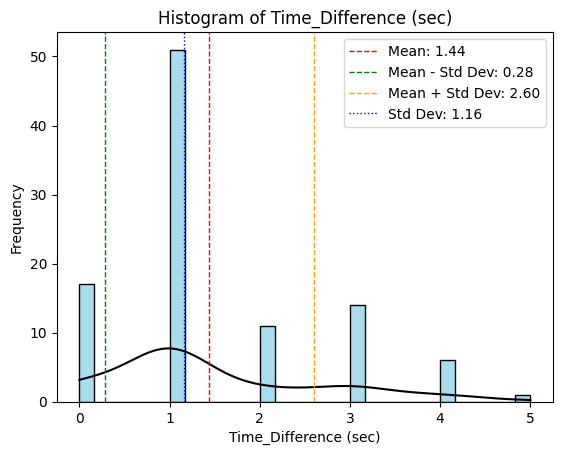

In [191]:
# --- Numeric visualizations (count, mean and standard deviation) --- #

# Time Difference

feature = 'Time_Difference (sec)'
data_ = selected_data[feature]
mean = np.mean(data_)
std_dev = np.std(data_)

ax = sns.histplot(data_, bins=30, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
ax.lines[0].set_color('black')

plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean - Std Dev: {mean - std_dev:.2f}')
plt.axvline(mean + std_dev, color='orange', linestyle='dashed', linewidth=1, label=f'Mean + Std Dev: {mean + std_dev:.2f}')
plt.axvline(std_dev, color='blue', linestyle='dotted', linewidth=1, label=f'Std Dev: {std_dev:.2f}')

plt.legend(loc='upper right')

plt.title(f'Histogram of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()


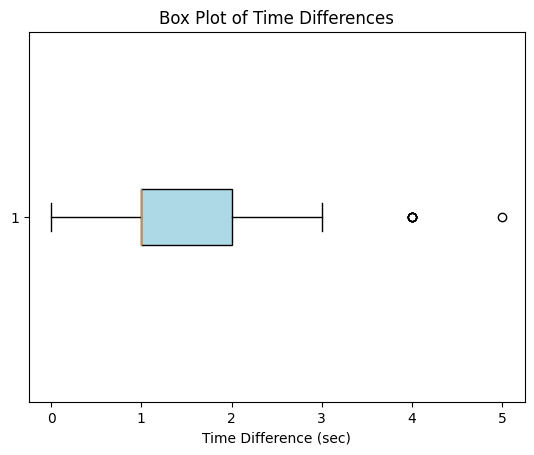

In [193]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have your data loaded in a DataFrame named 'selected_data'
time_differences = selected_data['Time_Difference (sec)']

# Create a box plot with colored boxes
fig, ax = plt.subplots()
box = ax.boxplot(time_differences, vert=False, patch_artist=True)

# Add color to the boxes
colors = ['lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and a title
plt.xlabel('Time Difference (sec)')
plt.title('Box Plot of Time Differences')

# Display the box plot
plt.show()


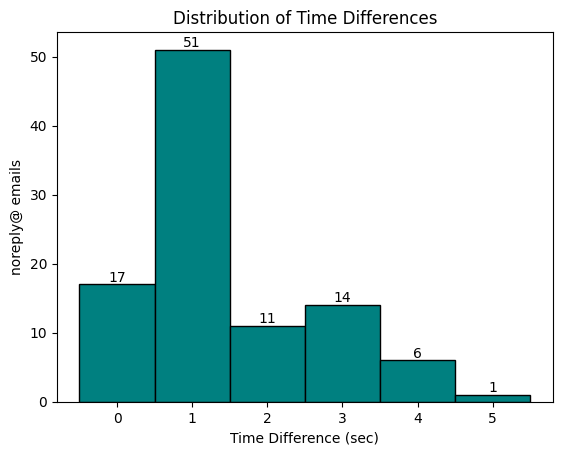

In [194]:
import matplotlib.pyplot as plt

# reading data
time_differences = selected_data['Time_Difference (sec)']

# Defining the bin edges and also ensuring that they are centered
bin_edges = [i - 0.5 for i in range(7)]
bin_edges.append(max(time_differences) + 0.5)

# Creating a histogram with centered bars and a new color (teal)
plt.hist(time_differences, bins=bin_edges, color='#008080', edgecolor='black', align='mid')

# Add labels and a title
plt.xlabel('Time Difference (sec)')
plt.ylabel('noreply@ emails')
plt.title('Distribution of Time Differences')

# Displaying the histogram
for i in range(6):
    count = len([x for x in time_differences if bin_edges[i] <= x < bin_edges[i + 1]])
    plt.text((bin_edges[i] + bin_edges[i + 1]) / 2, count, str(count), ha='center', va='bottom')

plt.show()

In [195]:
# Extracting specific columns
selected_columns = ['From','Sent_time_and_timezone','X-Received_time_and_timezone','Received_1_time_and_timezone','Received_2_time_and_timezone','Received_3_time_and_timezone','Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 0]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
5,Google Forms <forms-receipts-noreply@google.com>,15:11:56 +0000,08:11:56 -0700,08:11:56 -0700,08:11:56 -0700,NaN,0.0
11,Google Cloud Platform <CloudPlatform-noreply@g...,23:25:11 -0700,23:25:11 -0700,23:25:11 -0700,23:25:11 -0700,NaN,0.0
21,Google Scholar Alerts <scholaralerts-noreply@g...,03:20:41 -0800,03:20:41 -0800,03:20:41 -0800,03:20:41 -0800,NaN,0.0
22,Google Scholar Alerts <scholaralerts-noreply@g...,05:44:52 -0800,05:44:52 -0800,05:44:52 -0800,05:44:52 -0800,NaN,0.0
24,Google Scholar Alerts <scholaralerts-noreply@g...,04:54:54 -0700,04:54:54 -0700,04:54:54 -0700,04:54:54 -0700,NaN,0.0
27,Google Scholar Alerts <scholaralerts-noreply@g...,06:31:14 -0800,06:31:14 -0800,06:31:14 -0800,06:31:14 -0800,NaN,0.0
28,Google Scholar Alerts <scholaralerts-noreply@g...,05:38:09 -0700,05:38:09 -0700,05:38:09 -0700,05:38:09 -0700,NaN,0.0
45,Google Scholar Alerts <scholaralerts-noreply@g...,23:34:03 -0700,23:34:03 -0700,23:34:03 -0700,23:34:03 -0700,NaN,0.0
47,Google Scholar Alerts <scholaralerts-noreply@g...,06:58:58 -0700,06:58:58 -0700,06:58:58 -0700,06:58:58 -0700,NaN,0.0
58,Tshepiso <noreply@github.com>,22:25:37 -0700,22:25:37 -0700,22:25:37 -0700,22:25:37 -0700,22:25:37 -0700,0.0


In [196]:
# Assuming your DataFrame is named 'selected_data'
selected_columns = ['From','Sent_time_and_timezone', 'X-Received_time_and_timezone', 'Received_1_time_and_timezone', 'Received_2_time_and_timezone', 'Received_3_time_and_timezone', 'Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 1]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
0,Japan-Africa / Latin America Coding Contest 20...,23:00:31 +0000,16:00:32 -0700,16:00:32 -0700,16:00:32 -0700,NaN,1.0
2,Clementine Mashile via LinkedIn\n <messaging-d...,15:21:40 +0000,07:21:41 -0800,07:21:41 -0800,07:21:41 -0800,NaN,1.0
3,Google Forms <forms-receipts-noreply@google.com>,15:43:42 +0000,08:43:43 -0700,08:43:43 -0700,08:43:42 -0700,NaN,1.0
4,Google Forms <forms-receipts-noreply@google.com>,16:03:10 +0000,09:03:11 -0700,09:03:11 -0700,09:03:11 -0700,NaN,1.0
6,Google Forms <forms-receipts-noreply@google.com>,15:54:02 +0000,08:54:03 -0700,08:54:03 -0700,08:54:03 -0700,NaN,1.0
7,Google Forms <forms-receipts-noreply@google.com>,15:27:42 +0000,08:27:42 -0700,08:27:43 -0700,08:27:42 -0700,NaN,1.0
8,Google Forms <forms-receipts-noreply@google.com>,15:11:17 +0000,08:11:18 -0700,08:11:18 -0700,08:11:18 -0700,NaN,1.0
10,Google Cloud Platform <CloudPlatform-noreply@g...,08:16:14 -0700,08:16:14 -0700,08:16:15 -0700,08:16:14 -0700,NaN,1.0
23,Google Scholar Alerts <scholaralerts-noreply@g...,01:38:53 -0700,01:38:53 -0700,01:38:54 -0700,01:38:53 -0700,NaN,1.0
25,Google Scholar Alerts <scholaralerts-noreply@g...,04:34:40 -0700,04:34:41 -0700,04:34:41 -0700,04:34:41 -0700,NaN,1.0


In [197]:
# Assuming your DataFrame is named 'selected_data'
selected_columns = ['From','Sent_time_and_timezone', 'X-Received_time_and_timezone', 'Received_1_time_and_timezone', 'Received_2_time_and_timezone', 'Received_3_time_and_timezone', 'Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 2]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
13,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:59:49 +0000,02:59:51 -0700,02:59:51 -0700,02:59:50 -0700,NaN,2.0
31,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,11:54:01 +0000,04:54:03 -0700,04:54:03 -0700,04:54:03 -0700,NaN,2.0
32,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,11:54:02 +0000,04:54:04 -0700,04:54:04 -0700,04:54:04 -0700,NaN,2.0
53,Medium Daily Digest <noreply@medium.com>,05:00:00 +0000,22:00:02 -0700,22:00:02 -0700,22:00:02 -0700,NaN,2.0
56,"""Wondershare"" <noreply@mail-service.wondershar...",16:09:51 +0800,01:09:53 -0700,01:09:53 -0700,01:09:53 -0700,16:09:51 +0800,2.0
80,Filmora <noreply@best.wondershare.com>,13:25:23 +0000,06:25:25 -0700,06:25:25 -0700,06:25:25 -0700,NaN,2.0
84,"""Wondershare"" <noreply@mail-service.wondershar...",10:03:27 +0800,18:03:28 -0800,18:03:29 -0800,18:03:28 -0800,10:03:27 +0800,2.0
85,"""Wondershare"" <noreply@mail-service.wondershar...",20:09:37 +0800,04:09:38 -0800,04:09:39 -0800,04:09:38 -0800,20:09:37 +0800,2.0
89,Azeez Olanrewaju Shoderu via LinkedIn\n <messa...,09:32:00 +0000,02:32:02 -0700,02:32:02 -0700,02:32:02 -0700,NaN,2.0
93,"""Wondershare"" <noreply@mail-service.wondershar...",19:27:35 +0800,03:27:36 -0800,03:27:37 -0800,03:27:36 -0800,19:27:35 +0800,2.0


In [198]:
# Assuming your DataFrame is named 'selected_data'
selected_columns = ['From','Sent_time_and_timezone', 'X-Received_time_and_timezone', 'Received_1_time_and_timezone', 'Received_2_time_and_timezone', 'Received_3_time_and_timezone', 'Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 3]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
1,"""Clarence Sithole (via LinkedIn)"" <messages-no...",05:25:09 +0000,21:25:12 -0800,21:25:12 -0800,21:25:12 -0800,NaN,3.0
9,Google Cloud Platform <CloudPlatform-noreply@g...,08:01:54 -0700,08:01:56 -0700,08:01:57 -0700,08:01:56 -0700,NaN,3.0
12,Business Insider via LinkedIn <newsletters-nor...,11:21:51 +0000,04:21:53 -0700,04:21:54 -0700,04:21:53 -0700,NaN,3.0
14,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:50:26 +0000,02:50:28 -0700,02:50:29 -0700,02:50:28 -0700,NaN,3.0
15,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:54:08 +0000,02:54:11 -0700,02:54:11 -0700,02:54:11 -0700,NaN,3.0
16,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:55:59 +0000,02:56:02 -0700,02:56:02 -0700,02:56:02 -0700,NaN,3.0
20,Business Insider via LinkedIn <newsletters-nor...,20:00:17 +0000,13:00:19 -0700,13:00:20 -0700,13:00:19 -0700,NaN,3.0
29,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,12:11:11 +0000,05:11:13 -0700,05:11:14 -0700,05:11:13 -0700,NaN,3.0
30,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,12:11:11 +0000,05:11:13 -0700,05:11:14 -0700,05:11:13 -0700,NaN,3.0
42,Medium Daily Digest <noreply@medium.com>,05:00:00 +0000,22:00:02 -0700,22:00:03 -0700,22:00:02 -0700,NaN,3.0


In [199]:
# Assuming your DataFrame is named 'selected_data'
selected_columns = ['From','Sent_time_and_timezone', 'X-Received_time_and_timezone', 'Received_1_time_and_timezone', 'Received_2_time_and_timezone', 'Received_3_time_and_timezone', 'Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 4]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
17,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,10:17:55 +0000,03:17:59 -0700,03:17:59 -0700,03:17:59 -0700,NaN,4.0
19,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:53:33 +0000,02:53:37 -0700,02:53:37 -0700,02:53:37 -0700,NaN,4.0
33,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,13:12:20 +0000,06:12:24 -0700,06:12:24 -0700,06:12:24 -0700,NaN,4.0
48,Medium Daily Digest <noreply@medium.com>,05:00:00 +0000,22:00:03 -0700,22:00:04 -0700,22:00:03 -0700,NaN,4.0
55,LinkedIn <messages-noreply@linkedin.com>,19:14:19 +0000,12:14:23 -0700,12:14:23 -0700,12:14:23 -0700,NaN,4.0
96,GitHub via LinkedIn <newsletters-noreply@linke...,21:08:08 +0000,13:08:11 -0800,13:08:12 -0800,13:08:11 -0800,NaN,4.0


In [200]:
# Assuming your DataFrame is named 'selected_data'
selected_columns = ['From','Sent_time_and_timezone', 'X-Received_time_and_timezone', 'Received_1_time_and_timezone', 'Received_2_time_and_timezone', 'Received_3_time_and_timezone', 'Time_Difference (sec)']
selected_columns = data[selected_columns]

# selecting rows with time difference of 0
rows_with_zero_time_difference = selected_columns[selected_columns['Time_Difference (sec)'] == 5]

rows_with_zero_time_difference

,From,Sent_time_and_timezone,X-Received_time_and_timezone,Received_1_time_and_timezone,Received_2_time_and_timezone,Received_3_time_and_timezone,Time_Difference (sec)
18,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,09:47:16 +0000,02:47:21 -0700,02:47:21 -0700,02:47:21 -0700,NaN,5.0
